# Youtube Spam Detection

---
## Data cleaning
First we need to import the dataset to clean it by removing unnecessary features. We also remove possible duplicates and add some meaningful features. Finally we split the training and testing data with a 70/30 ratio.

In [86]:
import pandas as pd
import nltk
import glob
import emoji
from sklearn.model_selection import train_test_split

In [87]:
# importing the csv dataset files and concatenating them 
df = pd.concat([pd.read_csv(f, encoding='utf8') for f in glob.glob('datasets/*.csv')], ignore_index=True)

# dropping three unused features:
# COMMENT_ID, as it is autogenerated by YouTube and not useful
# DATE, as all dates of spam comments in eminem.csv are null
df.drop(labels=['COMMENT_ID', 'DATE'], axis=1, inplace=True)

# renaming the columns
df.columns = ['author','comment','label']

# counts special characters in a comment
def specials(x):
  count = 0
  for i in x:
    if (not(i.isalpha() or i.isdigit() or i == ' ')):
      count += 1
  return count

# counts upper case characters in a comment
def upper_cases(x):
  count = 0
  for i in x:
    if (i.isupper()):
      count += 1
  return count

# checks if there are numbers in a comment
def numbers(x):
  for i in x:
    if (i.isdigit()):
      return 1
  return 0

# checks if there are links in a comment
def links(x):
  link = ['/watch?', 'http', 'https', 'www.', '.com', 'adf.ly', 'HTTP', 'HTTPS', 'WWW.', '.COM']
  for i in link:
    if x.find(i) != -1:
      return 1
  return 0

# checks if there are emojis in a comment
def emojis(x):
  if (emoji.emoji_count(x) > 0):
    return 1
  return 0

nltk.download('punkt')
# adding features such as number of characters, words, sentences, special and upper case characters. 
# also the presence of numbers, links and emojis.
df['chars'] = df['comment'].apply(len)
df['words'] = df.apply(lambda row: nltk.word_tokenize(row['comment']), axis=1).apply(len)
df['sentences'] = df.apply(lambda row: nltk.sent_tokenize(row['comment']), axis=1).apply(len)
df['specials']=df['comment'].apply(specials)
df['upper_cases']=df['comment'].apply(upper_cases)
df['numbers']=df['comment'].apply(numbers)
df['links']=df['comment'].apply(links)
df['emojis']=df['comment'].apply(emojis)

Y = df['label']
X = df.drop(['label'],axis=1)
  
# separating training and testing data (70/30), with stratification on 'label'
X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify = Y, train_size = 0.7, test_size = 0.3)

df.describe()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,chars,words,sentences,specials,upper_cases,numbers,links,emojis
count,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000
mean,0.513804,94.703476,21.212679,1.810838,8.127812,9.138548,0.338446,0.132924,0.031697
std,0.499937,128.240427,32.558659,2.098350,22.560995,26.003221,0.473302,0.339580,0.175238
min,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,6.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,48.000000,10.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000
75%,1.000000,97.000000,21.000000,2.000000,8.000000,6.000000,1.000000,0.000000,0.000000
max,1.000000,1200.000000,697.000000,25.000000,696.000000,351.000000,1.000000,1.000000,1.000000


In [88]:
df.head(5)

,author,comment,label,chars,words,sentences,specials,upper_cases,numbers,links,emojis
0,Lisa Wellas,+447935454150 lovely girl talk to me xxx﻿,1,41,7,1,2,0,1,0,0
1,jason graham,I always end up coming back to this song<br />﻿,0,47,14,1,4,1,0,0,0
2,Ajkal Khan,"my sister just received over 6,500 new <a rel=...",1,201,45,3,28,2,1,1,0
3,Dakota Taylor,Cool﻿,0,5,1,1,1,1,0,0,0
4,Jihad Naser,Hello I&#39;am from Palastine﻿,1,30,9,1,4,3,1,0,0


In [89]:
df.tail(5)

,author,comment,label,chars,words,sentences,specials,upper_cases,numbers,links,emojis
1951,Katie Mettam,I love this song because we sing it at Camp al...,0,58,15,2,2,2,0,0,0
1952,Sabina Pearson-Smith,I love this song for two reasons: 1.it is abou...,0,93,19,1,3,3,1,0,0
1953,jeffrey jules,wow,0,3,1,1,0,0,0,0,0
1954,Aishlin Maciel,Shakira u are so wiredo,0,23,5,1,0,1,0,0,0
1955,Latin Bosch,Shakira is the best dancer,0,26,5,1,0,1,0,0,0


---
## Data analysis
Now we start analyzing the data with various graphs:

- Histograms to show the distribution of spam/ham comments in the dataset, training set and testing set
- Heatmap to see the correlation between features
- Histograms for characters, special and upper case character counts in ham/spam
- Countplots for number, link and emoji frequencies in ham/spam
- Word Cloud to show the most used word in spam comments
- Histograms to display the frequency of the 25 most used words in all comments and in spam comments.

In [90]:
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from PIL import Image

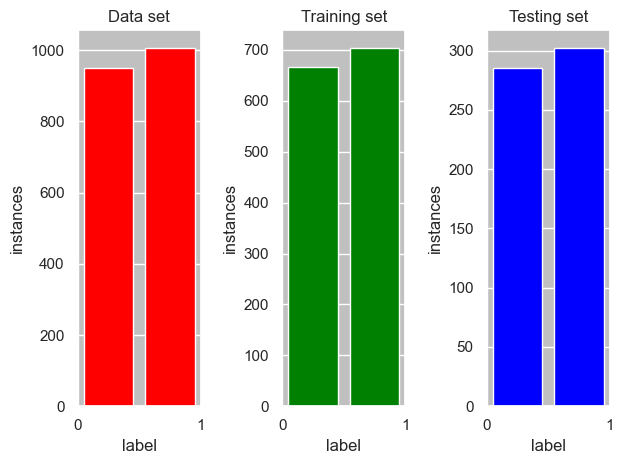

In [91]:
# histogram to show the distribution of spam/ham comments in the dataset, training set and testing set
figure, graph = plt.subplots(1, 3)

graph[0].set_title('Data set')
graph[0].hist(Y, bins=[0,0.5,1], color='red', rwidth=0.8)
graph[0].set_xlabel('label')
graph[0].set_xticks(np.arange(0, 2, 1))
graph[0].set_ylabel('instances')
graph[0].set_facecolor('silver')

graph[1].set_title('Training set')
graph[1].hist(y_train, bins=[0,0.5,1], color ='green', rwidth=0.8)
graph[1].set_xlabel('label')
graph[1].set_xticks(np.arange(0, 2, 1))
graph[1].set_ylabel('instances')
graph[1].set_facecolor('silver')

graph[2].set_title('Testing set')
graph[2].hist(y_test, bins=[0,0.5,1], color= 'blue', rwidth=0.8)
graph[2].set_xlabel('label')
graph[2].set_xticks(np.arange(0, 2, 1))
graph[2].set_ylabel('instances')
graph[2].set_facecolor('silver')

plt.tight_layout()
plt.show()

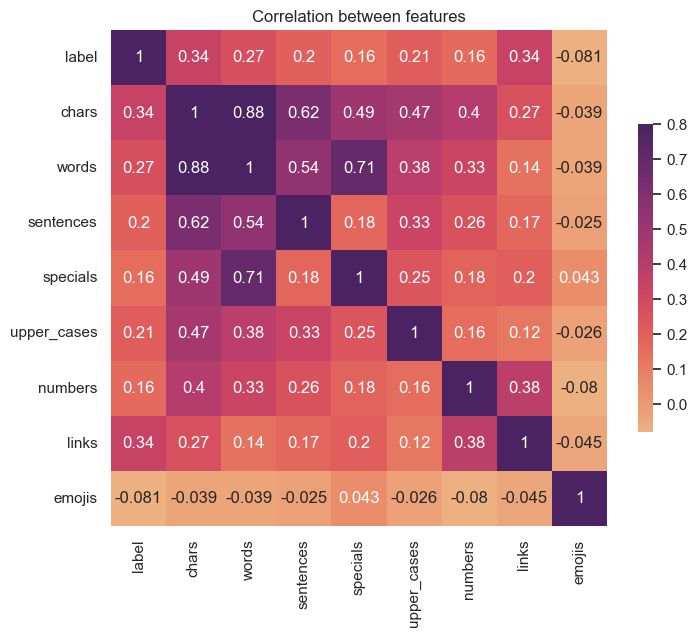

In [92]:
# heatmap to check the correlation between features
correlation_matrix = df.corr(numeric_only=True)
sns.set(font_scale=1)
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, vmax=.8, square=True, annot=True, cmap='flare', cbar_kws={'shrink': .5})

plt.title('Correlation between features')
plt.show()

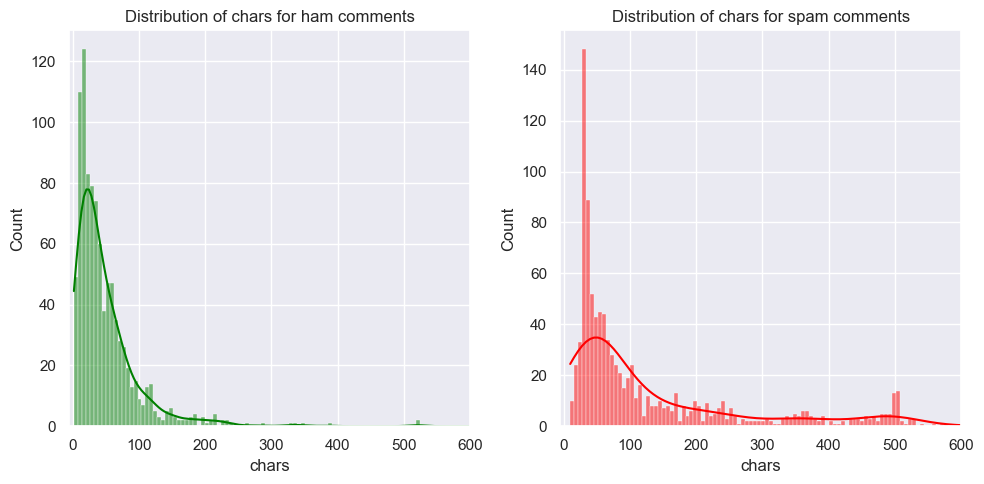

In [93]:
# distribution of characters count for ham/spam comments
plt.figure(figsize=(10, 5))

p = plt.subplot(1, 2, 1)
p.set_xlim(-5, 600)
sns.histplot(df[df['label']==0].chars, binwidth=6, bins=100, color='green', kde=True)
plt.title('Distribution of chars for ham comments')

g = plt.subplot(1, 2, 2)
g.set_xlim(-5, 600)
sns.histplot(df[df['label']==1].chars, binwidth=6, bins=100, color='red', kde=True)
plt.title('Distribution of chars for spam comments')

plt.tight_layout()
plt.show()

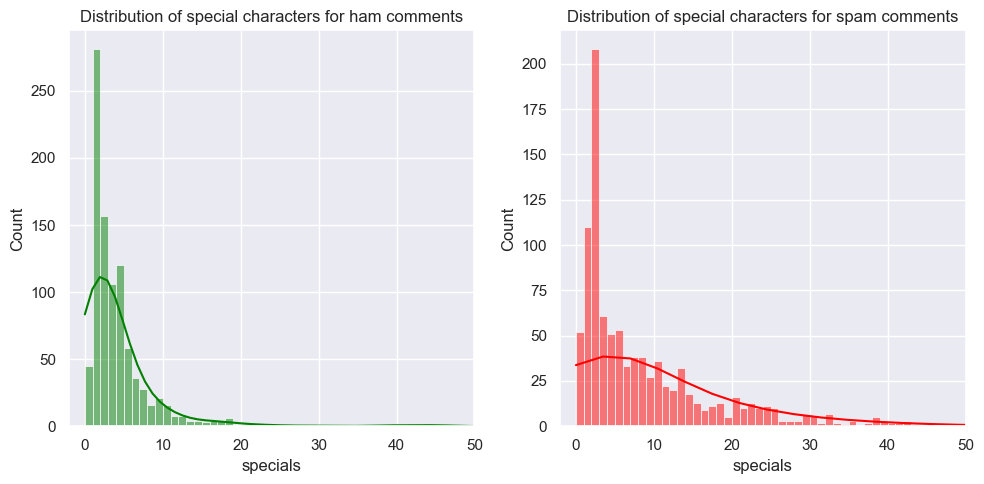

In [94]:
# distribution of special character count for ham/spam comments
plt.figure(figsize=(10, 5))

p = plt.subplot(1, 2, 1)
p.set_xlim(-2, 50)
sns.histplot(df[df['label']==0].specials, binwidth=1, bins=100, color='green', kde=True)
plt.title('Distribution of special characters for ham comments')

g = plt.subplot(1, 2, 2)
g.set_xlim(-2, 50)
sns.histplot(df[df['label']==1].specials, binwidth=1, bins=100, color='red', kde=True)
plt.title('Distribution of special characters for spam comments')

plt.tight_layout()
plt.show()

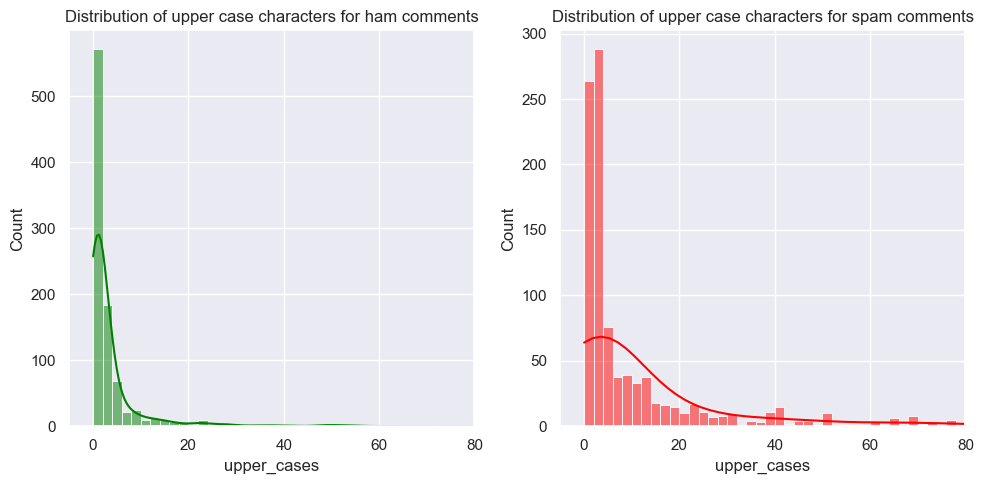

In [95]:
# distribution of upper case character count for ham/spam comments
plt.figure(figsize=(10, 5))

p = plt.subplot(1, 2, 1)
p.set_xlim(-5, 80)
sns.histplot(df[df['label']==0].upper_cases, binwidth=2, bins=100, color='green', kde=True)
plt.title('Distribution of upper case characters for ham comments')

g = plt.subplot(1, 2, 2)
g.set_xlim(-5, 80)
sns.histplot(df[df['label']==1].upper_cases, binwidth=2, bins=100, color='red', kde=True)
plt.title('Distribution of upper case characters for spam comments')

plt.tight_layout()
plt.show()

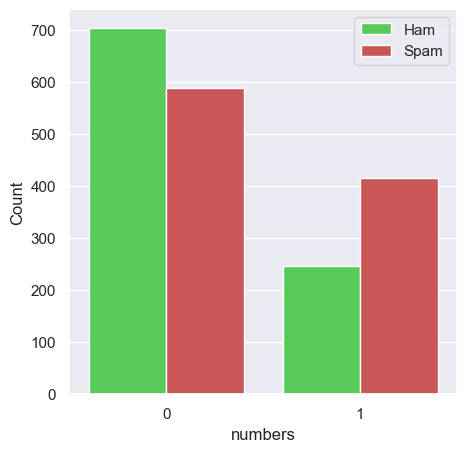

In [96]:
# distribution of numbers for ham/spam comments
plt.figure(figsize=(5,5))
sns.countplot(x='numbers', data=df, hue='label', palette='blend:#4D4,#D44')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'])
plt.show()

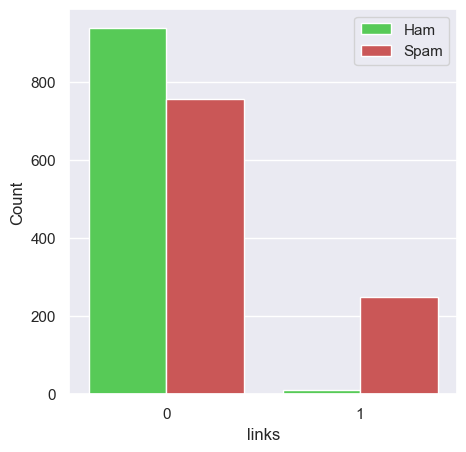

In [97]:
# distribution of links for ham/spam comments
plt.figure(figsize=(5,5))
sns.countplot(x='links', data=df, hue='label', palette='blend:#4D4,#D44')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'])
plt.show()

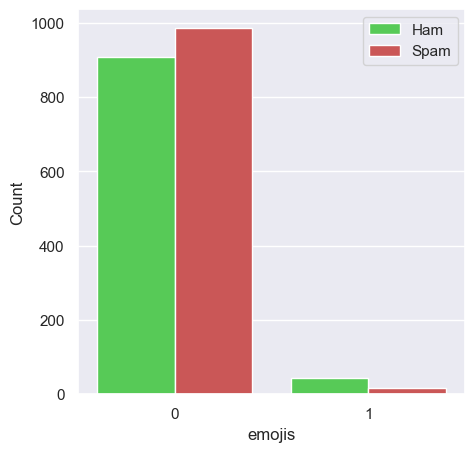

In [98]:
# distribution of emojis for ham/spam comments
plt.figure(figsize=(5,5))
sns.countplot(x='emojis', data=df, hue='label', palette='blend:#4D4,#D44')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'])
plt.show()

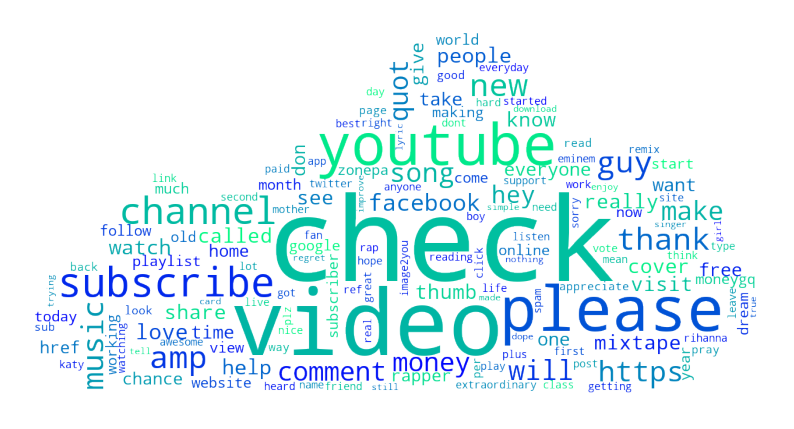

In [99]:
# word cloud with the most frequent words in the spam comments
spam_comments = df[Y==1]['comment']
words = ''

for message in spam_comments:
    words += message.lower()

mask = np.array(Image.open('cloud.png'))
wordcloud = WordCloud(max_font_size=150, normalize_plurals=True, min_word_length=3, collocations=False, max_words=150, colormap='winter', 
                      stopwords=set(STOPWORDS), background_color='rgba(255, 255, 255, 0)', mode='RGBA', mask=mask).generate(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

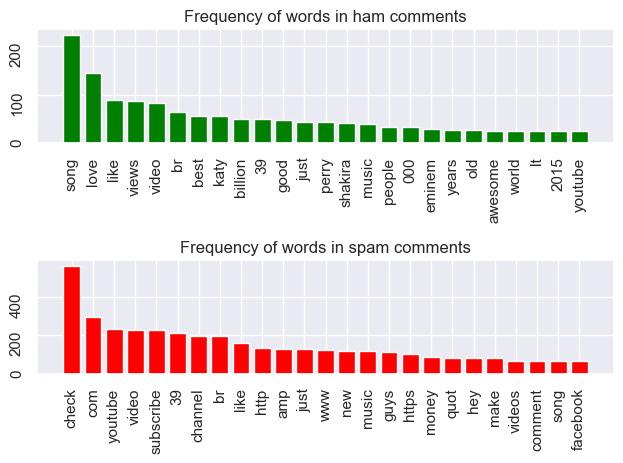

In [100]:
# returns the most n used words and their frequency
def word_freq(words, n):
    cv = CountVectorizer(stop_words = 'english').fit(words)
    bag_of_words = cv.transform(words)
    words_sum = bag_of_words.sum(axis=0) 
    words_freq = [(word, words_sum[0, x]) for word, x in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda y: y[1], reverse=True)
    return words_freq[:n]

_, graph = plt.subplots(2)

# most used words in ham comments
ham_comments = df[Y==0]['comment']
common_words = word_freq(ham_comments, 25)
df1 = pd.DataFrame(common_words, columns = ['comment_words', 'count'])
df1.groupby('comment_words').sum()['count'].sort_values(ascending=False)
graph[0].bar(x=df1['comment_words'], height=df1['count'], color='green')
graph[0].set_title('Frequency of words in ham comments')
graph[0].tick_params(labelrotation=90)

# most used words in spam comments
common_words = word_freq(spam_comments, 25)
df2 = pd.DataFrame(common_words, columns = ['comment_words', 'count'])
df2.groupby('comment_words').sum()['count'].sort_values(ascending=False)
graph[1].bar(x=df2['comment_words'], height=df2['count'], color='red')
graph[1].set_title('Frequency of words in spam comments')
graph[1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

---
## Classification and Results
Finally we start the classification. Count Vectorizer is used to tokenize the text of the comments, remove accents, punctuation and stop words.

Various classifiers from different families were chosen to experiment with their respective strenghts and weaknesses:

- K-Neighbors
- Gaussian with RBF
- SVM with SGD
- SVC
- Multinomial Naive Bayes
- Complement Naive Bayes
- Decision Tree
- Random Forest

and we validate the results with K-Cross-Validation, stratified with 5 folds.

In [101]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from prettytable import PrettyTable
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

In [102]:
# list of classifiers that will be used
classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1),
    SGDClassifier(),
    SVC(),
    MultinomialNB(),
    ComplementNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier()
]

# names of the classifiers
names = [
    'K-Neighbors',
    'Gaussian with RBF',
    'SVM with SGD',
    'SVC',
    'Multinomial Naive Bayes',
    'Complement Naive Bayes',
    'Decision Tree',
    'Random Forest'
]

In [107]:
# fit the classifier, compute metrics and plot roc curves
def classify(train_x, train_y, test_x, test_y):
    table = PrettyTable(['Classifier', 'Confusion Matrix', 'Accuracy', 'Precision', 'Recall', 'F1'])

    figure, graph = plt.subplots(2, 4)
    figure.set_figheight(10)
    figure.set_figwidth(20)
    row_num = 0
    col_num = 0

    for name, classifier in zip(names, classifiers):
        classifier.fit(train_x, train_y)
        predictions = classifier.predict(test_x)
        _matrix = confusion_matrix(test_y,predictions)
        _accuracy = format(accuracy_score(test_y,predictions))
        _precision = format(precision_score(test_y,predictions))
        _recall = format(recall_score(test_y,predictions))
        _f1 = format(f1_score(test_y,predictions))

        fpr, tpr, _ = roc_curve(test_y, predictions)
        roc_auc = auc(fpr, tpr)
        graph[row_num, col_num].plot([0, 1], [0, 1], color='black', linestyle='--')
        graph[row_num, col_num].plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
        graph[row_num, col_num].set_title(name+' ROC curve')
        graph[row_num, col_num].set_xlabel('False Positive Rate')
        graph[row_num, col_num].set_ylabel('True Positive Rate')
        graph[row_num, col_num].legend(loc='lower right')

        table.add_row([name, _matrix, _accuracy[0:5], _precision[0:5], _recall[0:5], _f1[0:5]])
        table.add_row(['', '', '', '', '', ''])
        col_num += 1
        if (col_num == 4):
            col_num = 0
            row_num += 1
    
    print(table)
    plt.tight_layout()
    plt.show()

+-------------------------+------------------+----------+-----------+--------+-------+
|        Classifier       | Confusion Matrix | Accuracy | Precision | Recall |   F1  |
+-------------------------+------------------+----------+-----------+--------+-------+
|       K-Neighbors       |    [[279   6]    |  0.836   |   0.972   | 0.701  | 0.815 |
|                         |    [ 90 212]]    |          |           |        |       |
|                         |                  |          |           |        |       |
|    Gaussian with RBF    |    [[273  12]    |  0.948   |   0.959   | 0.940  | 0.949 |
|                         |    [ 18 284]]    |          |           |        |       |
|                         |                  |          |           |        |       |
|       SVM with SGD      |    [[263  22]    |  0.940   |   0.929   | 0.956  | 0.942 |
|                         |    [ 13 289]]    |          |           |        |       |
|                         |                

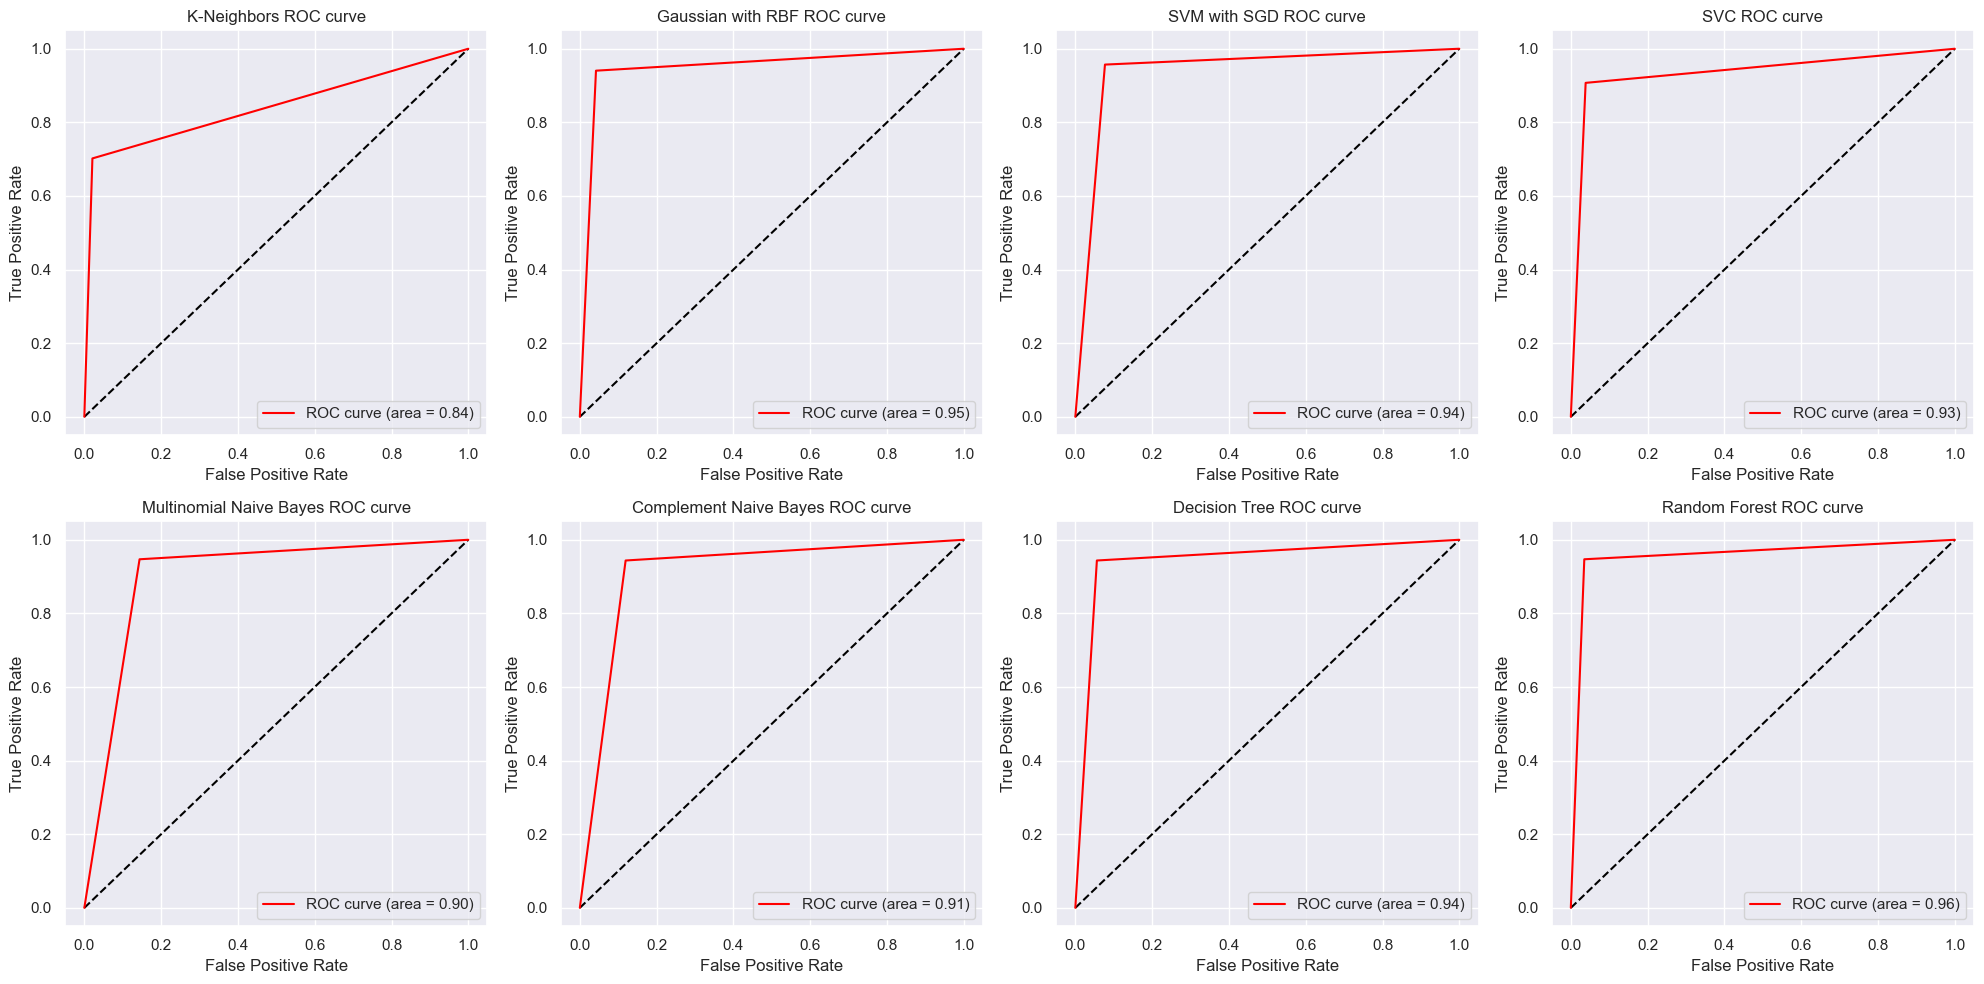

In [104]:
cv = CountVectorizer(strip_accents='unicode', stop_words='english')

cv_X_train = cv.fit_transform(X_train['comment']).toarray()
cv_X_test = cv.transform(X_test['comment']).toarray()

classify(cv_X_train,y_train,cv_X_test,y_test)

In [105]:
def k_fold_cross_validation(x,y,n):
    table = PrettyTable(['Classifier', 'Confusion Matrix', 'AVG Accuracy', 'AVG Precision', 'AVG Recall', 'AVG F1'])
    skf = StratifiedKFold(n_splits=n)

    for name, classifier in zip(names, classifiers):

        _avg_accuracy = cross_val_score(classifier, x, y, cv=skf, scoring='accuracy')
        _avg_precision = cross_val_score(classifier, x, y, cv=skf, scoring='precision_macro')
        _avg_recall = cross_val_score(classifier, x, y, cv=skf, scoring='recall_macro')
        _avg_F1 = cross_val_score(classifier, x, y, cv=skf, scoring='f1_macro')

        predictions = cross_val_predict(classifier, x, y, cv=skf)
        matrix = confusion_matrix(y, predictions)

        table.add_row([name, matrix, round(_avg_accuracy.mean(), 3), round(_avg_precision.mean(), 3), round(_avg_recall.mean(), 3), round(_avg_F1.mean(), 3)])
        table.add_row(['','', '', '', '', ''])
    
    print(table)

In [106]:
cv_X = cv.transform(X['comment']).toarray()
k_fold_cross_validation(cv_X, Y, 5)

+-------------------------+------------------+--------------+---------------+------------+--------+
|        Classifier       | Confusion Matrix | AVG Accuracy | AVG Precision | AVG Recall | AVG F1 |
+-------------------------+------------------+--------------+---------------+------------+--------+
|       K-Neighbors       |    [[928  23]    |    0.831     |      0.86     |   0.835    | 0.828  |
|                         |    [308 697]]    |              |               |            |        |
|                         |                  |              |               |            |        |
|    Gaussian with RBF    |    [[910  41]    |     0.94     |     0.942     |    0.94    |  0.94  |
|                         |    [ 77 928]]    |              |               |            |        |
|                         |                  |              |               |            |        |
|       SVM with SGD      |    [[889  62]    |    0.931     |     0.941     |    0.93    | 0.924  |
